In [1]:
# !pip install wordcloud

In [2]:
import os, re
import spacy
import pickle
import string
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis.gensim
import multiprocessing as mp
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from pyLDAvis import sklearn as sklearn_lda
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Folder
folder = './training/Final/'
file =  folder + 'dataset.csv'

# Init
nlp = spacy.load("en_core_web_sm")
stemmer = SnowballStemmer('english',ignore_stopwords=True)
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
extra = ['datum','siem','®']
STOPLIST = ENGLISH_STOP_WORDS.union(punc)
STOPLIST = STOPLIST.union(extra)
SYMBOLS = "?:!.,;(){}|[]%'+*"


# Viz Init
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
frame = pd.read_csv(file, sep='|')
frame.head()

,content,industries,location,title,type_empl,url,wage,suburb,experiences,title_left_over
0,Public Safety Business Agency / Kedron Tempora...,Information & Communication Technology,Brisbane,DA,Permanent,https://www.seek.com.au/job/39018343?type=stan...,85572.0,Northern Suburbs,General,Data Analyst
1,Fantastic working culture Flexible work enviro...,Information & Communication Technology,Brisbane,SDA,Contract,https://www.seek.com.au/job/39007973?type=stan...,99961.0,CBD & Inner Suburbs,Senior,Senior Business Analyst
2,CBD Location 12 month contract Join this State...,Information & Communication Technology,Brisbane,DA,Contract,https://www.seek.com.au/job/38912693?type=stan...,174590.0,CBD & Inner Suburbs,General,Database Analyst
3,CBD Location Initial 3 month contract Join thi...,Information & Communication Technology,Brisbane,DA,Contract,https://www.seek.com.au/job/39037731?type=stan...,177450.0,CBD & Inner Suburbs,General,Data Analyst
4,CBD Location! Initial contract through till en...,Information & Communication Technology,Brisbane,SDA,Contract,https://www.seek.com.au/job/39003265?type=stan...,173550.0,CBD & Inner Suburbs,Senior,Senior Test Analyst


In [4]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 10 columns):
content            1569 non-null object
industries         1569 non-null object
location           1569 non-null object
title              1569 non-null object
type_empl          1569 non-null object
url                1569 non-null object
wage               1569 non-null float64
suburb             1569 non-null object
experiences        1569 non-null object
title_left_over    1569 non-null object
dtypes: float64(1), object(9)
memory usage: 122.7+ KB


In [5]:
# Remove website or any urls
frame['content'] = frame['content'].map(lambda row: re.sub(r"(((http|https):\/\/)?www[a-z\.\/-]+)","website",row))

# Remove Punctuation
frame['content'] = frame['content'].map(lambda row: re.sub(r"[(,\.!?;:)]","",row))

# To Lower
frame['content'] = frame['content'].map(lambda row: row.lower())

In [6]:
def tokenizeText(sample):
    tokens = nlp(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [re.sub(r"([0-9]+)","",tok) for tok in tokens]
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])

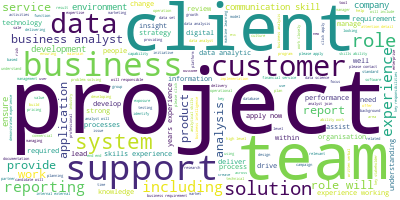

In [ ]:
# Join the different processed title together.
long_string = ','.join(list(frame['content'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# %%time
tp = TextPreprocessor(n_jobs=-1).fit(frame['content'])
new_content = tp.transform(frame['content'])

In [ ]:
type(new_content)

In [ ]:
frame['new_content'] = new_content
frame.info()

In [ ]:
# Join the different processed title together.
long_string = ','.join(list(frame['new_content'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
# Initialise the count vectorizer with the English stop words
vectorizer3 = TfidfVectorizer(stop_words=STOPLIST,tokenizer=tokenizeText,use_idf=True, max_features=2000)

# Fit and transform the contexts
count_data_2 = vectorizer3.fit_transform(frame['new_content'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data_2, vectorizer3)

In [ ]:
word_features3 = vectorizer3.get_feature_names()
len(word_features3)

In [ ]:
word_features3

In [ ]:
# Tweak the two parameters below
number_topics = 6
number_words = 14

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data_2)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer3, number_words)

In [ ]:
processed_docs = lda.transform(count_data_2)
print(len(processed_docs))
print(len(processed_docs[0]))


In [ ]:
dframe = pd.DataFrame(processed_docs)
dframe.head(10)

In [ ]:
# Push to dictionary
dictionary = gensim.corpora.Dictionary(processed_docs)

In [ ]:
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
print(LDAvis_data_filepath)

In [ ]:
count_data_2

In [ ]:
# LDA help vizualize
lda_display = pyLDAvis.gensim.prepare(lda, count_data_2, vectorizer3)
pyLDAvis.display(lda_display)

In [ ]:
%%time

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data_2, vectorizer3)
    with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath) as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')